# Trabajo Práctico 2: Análisis con Gradient Boost

**Alumnos y padron:**

Izquierdo Osorio, Stephanie. 104196 

Rosas, Martin Alejandro. 98535

---

## Preparación del entorno

In [1]:
import pandas as pd
import numpy as np
from preprocessing import *
from charts_and_write import *

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import preprocessing

## Carga y preparación del set de datos


In [2]:
download_raw_data()

Aplicamos un procesamiento para pasar las variables categoricas a numericas con onehotencoding

In [3]:
X_data = pd.read_csv("impuestos_train.cvs")
X_holdout= pd.read_csv("impuestos_holdout.cvs")

X_data, X_holdout = prepare_existing_data(X_data, X_holdout)

## Gradient Boosting

En gradient boosting se entrena un primer modelo sobre todo el set de entrenamiento. Luego se entrenan modelos subsiguientes a partir de los datos que el modelo anterior predijo mal. De esta forma la varianza total del ensamble es baja, porque cada modelo entrenado ponderará de forma distinta las observaciones. En general los ensambles tienen bajo sesgo, y en particular boosting logra bajar la varianza.

A cada instancia se le asigna inicialmente un peso, luego se predice y se recalculan los pesos, restandole importancia a las bien clasificadas para entrenar al modelo siguiente.

Los parametros a definir en Boosting son:

- **Loss**: la función de pérdida que se busca optimizar

- **Learning rate**: es la tasa de aprendizaje con la que se busca optimizar la función de pérdida anterior.

- **Número de estimadores**: es la cantidad de estimadores con los que se entrenará


In [4]:
parameters = {
    'learning_rate' : [0.1, 0.01, 0.001],
    'criterion' : ["mse", "friedman_mse"],
    'n_estimators' : [10, 50, 100]
}

### Version 1

In [5]:
columns_to_encode = ["estado_marital", "categoria_de_trabajo", "rol_familiar_registrado", "religion", "trabajo", "genero", "relacion_de_dependencia"]
X_data_1 = encode_one_hot(X_data, columns_to_encode)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_data_1.drop(columns={"tiene_alto_valor_adquisitivo"}), X_data_1["tiene_alto_valor_adquisitivo"], random_state=42)

In [7]:
model_gb_1 = GradientBoostingClassifier()
gsvc_1 = GridSearchCV(model_gb_1, parameters, verbose = 1, n_jobs=-1, cv=5, return_train_score=True, scoring='roc_auc')
gs_1_results = gsvc_1.fit(X_train, y_train)
gs_1_results.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   27.4s finished


{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'n_estimators': 100}

In [22]:
boost1 = GradientBoostingClassifier(n_estimators=100, learning_rate = 0.1, criterion='friedman_mse')
boost1.fit(X_train, y_train)
y_pred_1 = boost1.predict(X_test)

In [23]:
show_metrics(boost1, y_pred_1, y_test, X_test, "Boost 1")


Accuracy: 0.8715145559513573
----------------------------------------------
Precision: 0.6087182148417228
----------------------------------------------
Recall: 0.8006825938566553
----------------------------------------------
F1_score: 0.6916273584905659
----------------------------------------------
AUC-ROC score para Boost 1: 0.923


 Vemos que comenzamos con un recall alto pero con un presicion menor, vamos a ver si podemos mejorarlo

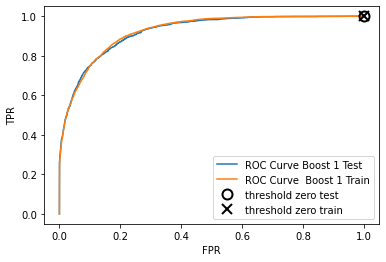

In [24]:
show_roc_curve(boost1, "Boost 1", X_test, X_train, y_test, y_train)

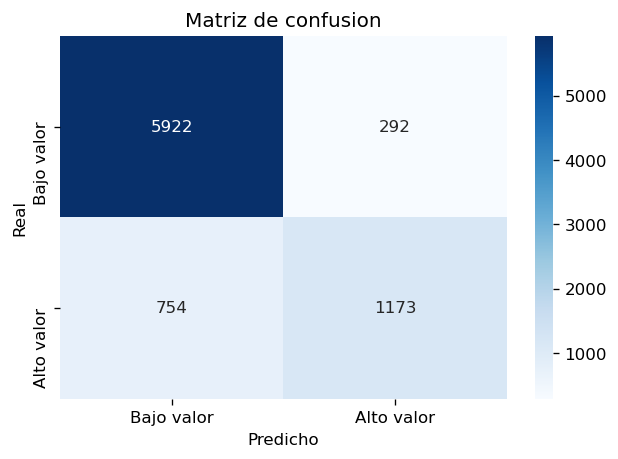

In [25]:
show_confusion_matrix(y_pred_1, y_test)

 ### Version 2

In [12]:
columns_to_sort = ["educacion", "edad", "bolsa"]
X_data_2 = encoding_sorted(X_data_1, columns_to_sort)

In [13]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_data_2.drop(columns={"tiene_alto_valor_adquisitivo"}), X_data_2["tiene_alto_valor_adquisitivo"], random_state=42)

In [14]:
model_gb_2 = GradientBoostingClassifier()
gsvc_2 = GridSearchCV(model_gb_2, parameters, verbose = 1, n_jobs=-1, cv=5, return_train_score=True, scoring='roc_auc')
gs_2_resultados = gsvc_2.fit(X_train_2, y_train_2)
gs_2_resultados.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   24.1s finished


{'criterion': 'mse', 'learning_rate': 0.1, 'n_estimators': 100}

In [15]:
boost2 = GradientBoostingClassifier(n_estimators=100, learning_rate = 0.1, criterion='mse')
boost2.fit(X_train_2, y_train_2)
y_pred_2 = boost2.predict(X_test_2)

In [16]:
show_metrics(boost2, y_pred_2, y_test_2, X_test_2, "Boost 2")


Accuracy: 0.8723744011792163
----------------------------------------------
Precision: 0.6107939802802284
----------------------------------------------
Recall: 0.8028649386084584
----------------------------------------------
F1_score: 0.6937813144709697
----------------------------------------------
AUC-ROC score para Boost 2: 0.924


Vemos que las metricas se mantuvieron y mejoro un poco el presicion

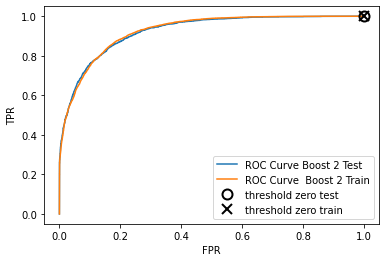

In [17]:
show_roc_curve(boost2, "Boost 2", X_test_2, X_train_2, y_test_2, y_train_2)

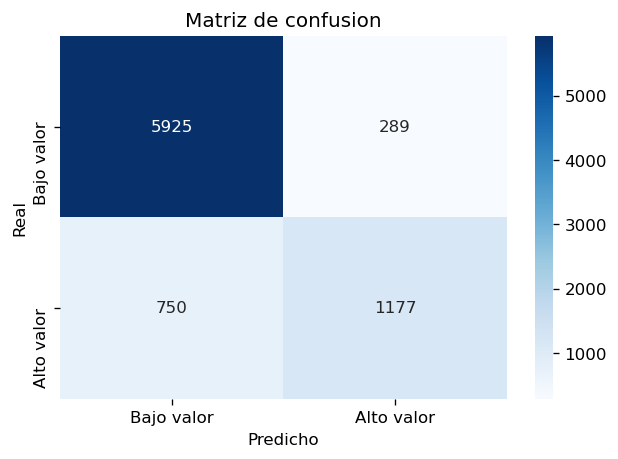

In [18]:
show_confusion_matrix(y_pred_2, y_test_2)

## Resultado

Utilizaremos la segunda version para predecir el nuevo archivo dado a que las metricas y la curva ROCAU es mejor

In [19]:
columns_to_encode = ["estado_marital", "categoria_de_trabajo", "rol_familiar_registrado", "religion", "trabajo", "genero", "relacion_de_dependencia"]
X_holdout = encode_one_hot(X_holdout, columns_to_encode)
X_holdout = encoding_sorted(X_holdout, columns_to_sort)

ids = np.array(X_holdout['id'])
X_holdout.drop(columns='id', inplace=True)

In [20]:
predictions_holdout = boost2.predict(X_holdout)

In [21]:
write_predictions(predictions_holdout,"boosting",ids)